In [20]:
import sys, os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

from tensorflow.keras.utils import img_to_array
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.applications.vgg16 import VGG16

In [21]:
train_dir = "/Users/taikisakai/git_rep/TransferLearning-CNN-/dataset/train"
test_dir = "/Users/taikisakai/git_rep/TransferLearning-CNN-/dataset/test"
img_size = 255
num_classes = 3
class_names = ["Crazing", "Inclusion", "Patches"]

In [22]:
augment = keras.Sequential(
    [layers.RandomFlip("horizontal_and_vertical"), 
     layers.RandomRotation(0.2)]
)

In [23]:
data_dir = "/Users/taikisakai/git_rep/TransferLearning-CNN-/dataset/"
INPUT_TFRECORD_TRAIN = os.path.join(data_dir, "train_tfrecords")
INPUT_TFRECORD_TEST = os.path.join(data_dir, "test_tfrecords")

In [24]:
class LoadTfrecords:

    def __init__(self, BATCH_SIZE):
        self.BATCH_SIZE = BATCH_SIZE


    def parse_train(self, serialized):
        features = {"image": tf.io.FixedLenFeature([], tf.string), 
                    "label": tf.io.FixedLenFeature([], tf.string)}
        
        parsed = tf.io.parse_single_example(serialized=serialized, 
                                            features=features)
        
        image_raw = parsed["image"]
        label_raw = parsed["label"]

        images = tf.io.decode_raw(image_raw, tf.uint8)
        images = tf.cast(images, tf.float32) / 255
        images = tf.reshape(images, [254, 254, 3])

        labels = tf.io.decode_raw(label_raw, tf.float32)
        labels = tf.reshape(labels, [3])

        return images, labels
    

    def parse_test(self, serialized):
        features = {"image": tf.io.FixedLenFeature([], tf.string), 
                    "label": tf.io.FixedLenFeature([], tf.string)}
        
        parsed = tf.io.parse_single_example(serialized=serialized, 
                                            features=features)
        
        image_raw = parsed["image"]
        label_raw = parsed["label"]

        images = tf.io.decode_raw(image_raw, tf.uint8)
        images = tf.cast(images, tf.float32) / 255
        images = tf.reshape(images, [254, 254, 3])

        labels = tf.io.decode_raw(label_raw, tf.float32)
        labels = tf.reshape(labels, [3])

        return images, labels


In [25]:
parse_data = LoadTfrecords(BATCH_SIZE=32)

trainset = tf.data.TFRecordDataset(INPUT_TFRECORD_TRAIN)
trainset = trainset.map(parse_data.parse_train)
trainset = trainset.shuffle(buffer_size=828)
trainset = trainset.repeat(-1)
trainset = trainset.batch(32)
trainset = trainset.prefetch(buffer_size=4)

testset = tf.data.TFRecordDataset(INPUT_TFRECORD_TEST)
testset = testset.map(parse_data.parse_test)
testset = testset.batch(32)
testset = testset.prefetch(buffer_size=2)

In [26]:
input = Input(shape=(254, 254, 3))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input)

In [27]:
x = base_model.output
x = Flatten(input_shape=base_model.output_shape[1:])(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(3, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 254, 254, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0   

In [28]:
for layer in base_model.layers:
    layer.trainable = False
    print('{}, {}'.format(layer, layer.trainable))

<keras.src.engine.input_layer.InputLayer object at 0x168c6afa0>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x168c65e80>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x168b27880>, False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x168ac0760>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x1655dafd0>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x168aad5b0>, False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x15f32df70>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x15f2eeee0>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x15f32d250>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x168c7bd00>, False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x16b134d00>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x16b1347f0>, False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x165036ca0>, Fa

In [29]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=["acc"])

In [30]:
history = model.fit(trainset, 
                    steps_per_epoch=828//32, 
                    epochs=10, 
                    validation_data=testset)

Epoch 1/10


25/25 [==============================] - 10s 389ms/step - loss: 1.0843 - acc: 0.4938 - val_loss: 0.5754 - val_acc: 0.9167
Epoch 2/10


2023-11-23 22:57:41.455578: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12278958357801169071
2023-11-23 22:57:41.455590: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13641910813884678407
2023-11-23 22:57:41.455594: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16924182304027069163
2023-11-23 22:57:41.455596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10505398685072539581
2023-11-23 22:57:41.455603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1286690624753509590


25/25 [==============================] - 10s 387ms/step - loss: 0.6147 - acc: 0.7362 - val_loss: 0.3574 - val_acc: 0.9722
Epoch 3/10
25/25 [==============================] - 10s 385ms/step - loss: 0.3894 - acc: 0.8838 - val_loss: 0.2591 - val_acc: 0.9722
Epoch 4/10
25/25 [==============================] - 10s 385ms/step - loss: 0.2869 - acc: 0.9212 - val_loss: 0.1983 - val_acc: 0.9722
Epoch 5/10
25/25 [==============================] - 10s 386ms/step - loss: 0.2196 - acc: 0.9500 - val_loss: 0.1622 - val_acc: 0.9722
Epoch 6/10
25/25 [==============================] - 10s 386ms/step - loss: 0.1832 - acc: 0.9588 - val_loss: 0.1392 - val_acc: 0.9722
Epoch 7/10
25/25 [==============================] - 10s 386ms/step - loss: 0.1606 - acc: 0.9613 - val_loss: 0.1297 - val_acc: 1.0000
Epoch 8/10
25/25 [==============================] - 10s 386ms/step - loss: 0.1386 - acc: 0.9675 - val_loss: 0.1077 - val_acc: 0.9722
Epoch 9/10
25/25 [==============================] - 10s 386ms/step - loss: 0.126

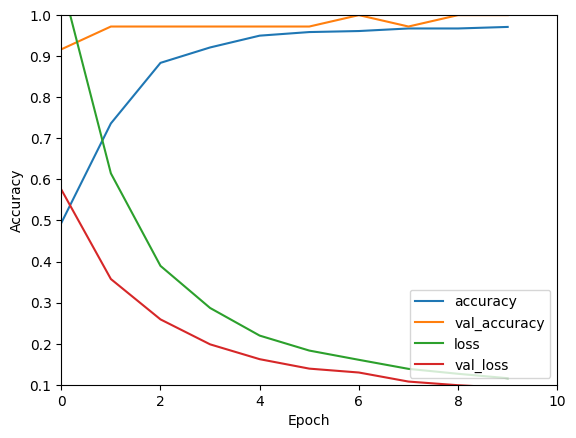

In [31]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.xlim([0, 10])
plt.legend(loc='lower right')